In [8]:
# 07/01/2023

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, silhouette_samples

In [9]:
df=pd.read_csv('Exam_data.csv')
df.head()

,A0,A1,A2,y
0,2067.582042,-15.259519,0.020472,2
1,1319.589579,-18.412320,0.521308,0
2,1170.212183,-19.470602,0.814986,0
3,1424.162191,9.867841,0.848751,1
4,1551.069098,11.809364,0.884964,1


In [10]:
X=df.drop('y',axis=1)
Y=df['y']
print(X.shape, Y.shape)

(1000, 3) (1000,)


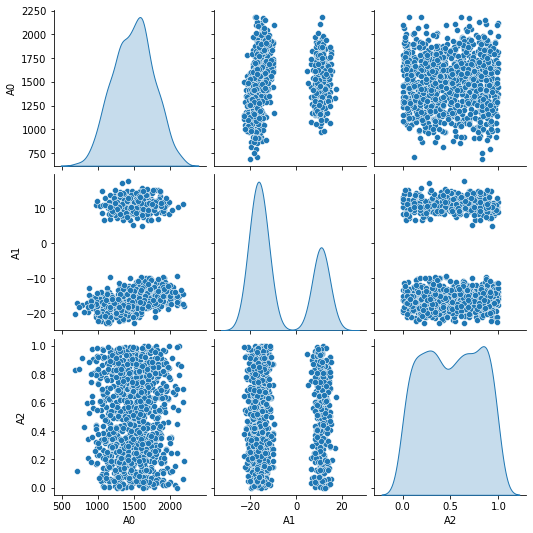

In [83]:
%matplotlib inline
sns.pairplot(X,diag_kind='kde')

 The data looks scattered and unseperable and only A1,A0 and A1,A2 seems seperable. Taking all A0, A1 and A2 columns 

Comparing KMeans and Agglomerative clustering to work with the best scheme.

In [6]:
def km_clustering():
    result=pd.DataFrame(columns=['n_clusters','inertia','silhouette_score'])
    parameters=[{'n_clusters': list(range(2,11))}]
    pg = list(ParameterGrid(parameters))
    inertia=[]
    silhouette=[]
    for i in range(len(pg)):
        km=KMeans(**(pg[i]))
        y_pred=km.fit_predict(X)
        result.loc[len(result)]=[pg[i]['n_clusters'],km.inertia_,silhouette_score(X,y_pred)]
#         inertia.append(km.inertia_)
#         silhouette.append(silhouette_score(X,y_pred))
    print(result[result.silhouette_score==result.silhouette_score.max()])
    
def ag_clustering():
    result=pd.DataFrame(columns=['linkage','n_clusters','silhouette_score'])
    parameters = [{'n_clusters': list(range(2,11))
                    , 'linkage' : ['ward', 'complete', 'average', 'single']}]
    pg = list(ParameterGrid(parameters))
    
    for i in range(len(pg)):
        ag=AgglomerativeClustering(**(pg[i]))
        y_pred=ag.fit_predict(X)
        result.loc[len(result)]=[pg[i]['linkage'],pg[i]['n_clusters'],silhouette_score(X,y_pred)]
    print(result[result.silhouette_score==result.silhouette_score.max()]) 
    
from sklearn.metrics import silhouette_score
model_lbls = [
              'KMeans', 
              'Agglomerative',  
            ]

for m in model_lbls:
    print('-'*40)
    print("Trying model {} Clustering".format(m))
    if m=='KMeans':
        km_clustering()
    elif m== 'Agglomerative':
        ag_clustering()

----------------------------------------
Trying model KMeans Clustering
   n_clusters       inertia  silhouette_score
0         2.0  2.519314e+07          0.568303
----------------------------------------
Trying model Agglomerative Clustering
    linkage  n_clusters  silhouette_score
0      ward           2          0.558875
9  complete           2          0.558875


KMeans gives a better score. So selecting KMeans scheme for clustering

Testing KMeans with varying number of clusters, from 2 to 10: for each value of k
1. fitting the data
2. computing the inertia and the silhouette score

In [11]:
inertia=[]
silhouette=[]
k_range=list(range(2,11))
parameters=[{'n_clusters': k_range }]
pg = list(ParameterGrid(parameters))
inertia=[]
silhouette=[]
result=pd.DataFrame(columns=['n_clusters','inertia','silhouette_score'])
for i in range(len(pg)):
    km=KMeans(**(pg[i]))
    y_pred=km.fit_predict(X)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X,y_pred))
    result.loc[len(result)]=[pg[i]['n_clusters'],km.inertia_,silhouette_score(X,y_pred)]

result

,n_clusters,inertia,silhouette_score
0,2.0,2.519314e+07,0.568303
1,3.0,1.307986e+07,0.533711
2,4.0,7.425335e+06,0.540968
3,5.0,5.276044e+06,0.513409
4,6.0,3.987227e+06,0.494809
5,7.0,2.865042e+06,0.516643
6,8.0,2.243136e+06,0.512825
7,9.0,1.893241e+06,0.504177
8,10.0,1.564438e+06,0.494248


We can see that silhouette score is max for k=2 but since it has quite more inertia than the inertia of k = 3 with the same silhouette it shouldn't be considered and next highest is k=4

Plot inertia and silhouette score versus k

In [12]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):

    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

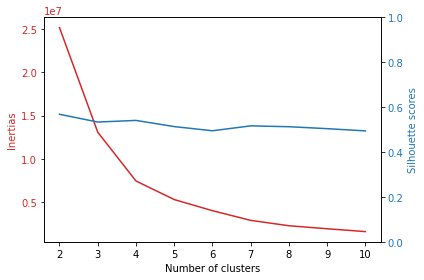

In [13]:
two_plots(x=k_range, y1=inertia, y2=silhouette
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

The two elbow points of inertia suggests cluster number 3 or 4, slightly more pronounced in 3. Silhouette score is greater at k=4.
Thus selecting optimal no of clusters k=4 for better generalization.

In [14]:
k=4
km = KMeans(n_clusters=k, 
            random_state=42)
y_km = km.fit_predict(X)
print("Number of clusters = {}\t- Distortion = {:6.2f}\t- Silhouette score = {:4.2f}"\
    .format(k,inertia[k_range.index(k)],silhouette[k_range.index(k)]))

Number of clusters = 4	- Distortion = 7425335.10	- Silhouette score = 0.54


C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


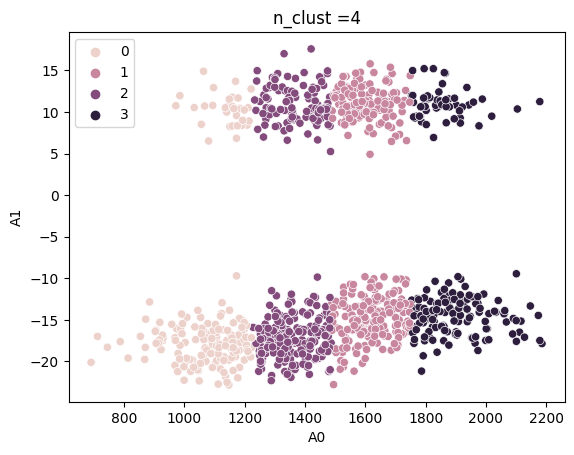

C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


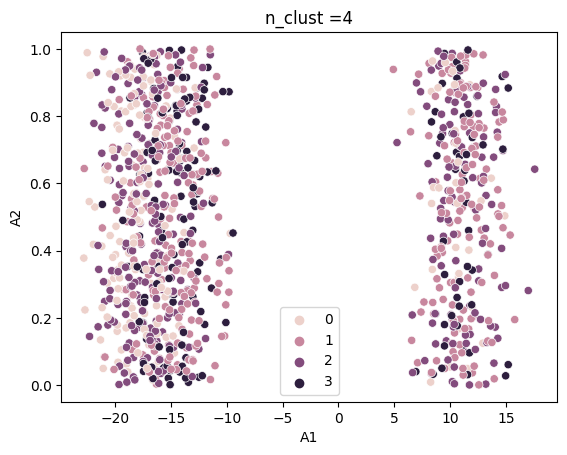

In [78]:
plt.title('n_clust =' + str(k))
sns.scatterplot(X['A0'],X['A1'],hue = y_km);
plt.show()

plt.title('n_clust =' + str(k))
sns.scatterplot(X['A1'],X['A2'],hue = y_km);
plt.show()

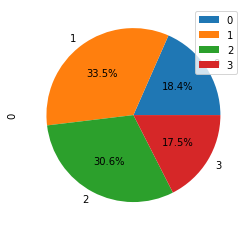

In [15]:
clust_sizes_km = np.unique(y_km,return_counts=True)
#print(clust_sizes_km)
pd.DataFrame(clust_sizes_km[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

Generating the pair confusion matrix to quantify the matching of the predicted data with the golden standard.

In [50]:
from sklearn.metrics import pair_confusion_matrix
#from max_diag import max_diag
pcm = pair_confusion_matrix(Y,y_km)
pcm=pcm / pcm.sum()
print("Confusion Matrix")
print(pcm,"\n")
print('The computed accuracy of the schema is {:.2f}%'.format(pcm.diagonal().sum()*100))


Confusion Matrix
[[0.52187187 0.14546146]
 [0.20851652 0.12415015]] 

The computed accuracy of the schema is 64.60%


The accuracy is not really good , so need to improve by applying some preprocessing on the data

1. Pruning the data feature A0

Shape of X_pruned: (1000, 2)


<Figure size 1000x1000 with 0 Axes>

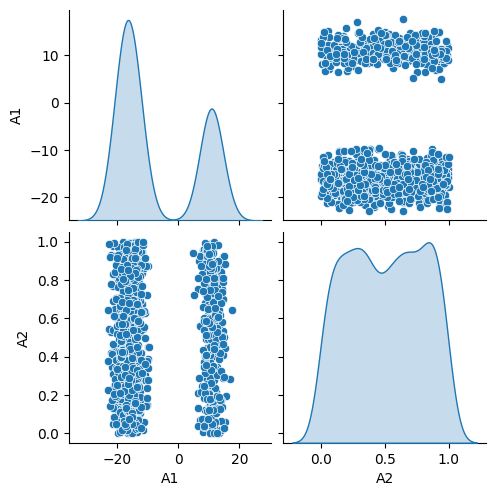

In [61]:
X_pruned = X.iloc[:,1:]
print(f'Shape of X_pruned: {X_pruned.shape}')
# produce a pairplot of X_pruned
plt.figure(figsize=(10, 10))
sns.pairplot(X_pruned, diag_kind='kde')

Retrying the clustering scheme without feature A0, i.e only with A1 and A2

In [62]:
k=4
km_pruned = KMeans(n_clusters=k, 
            random_state=42)
y_km_pruned = km_pruned.fit_predict(X_pruned)
print("Number of clusters = {}\t- Distortion = {:6.2f}\t- Silhouette score = {:4.2f}"\
    .format(k,km_pruned.inertia_,silhouette_score(X_pruned,y_km_pruned)))

Number of clusters = 4	- Distortion = 2272.35	- Silhouette score = 0.65


C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


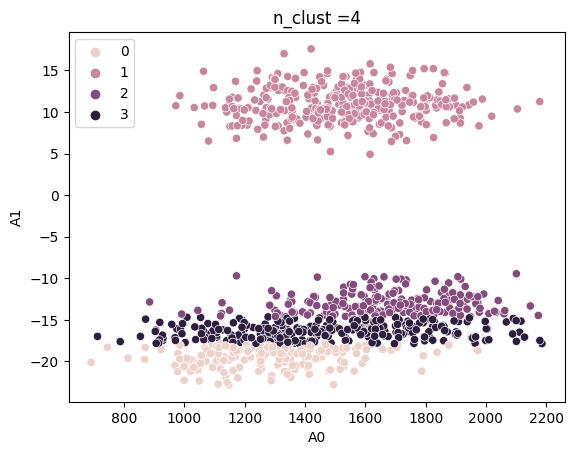

C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


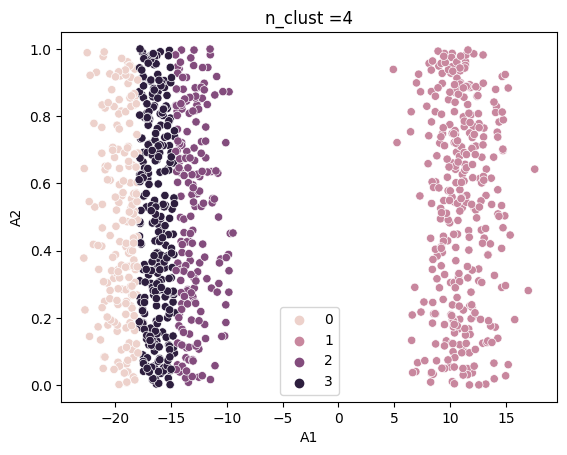

In [79]:
plt.title('n_clust =' + str(k))
sns.scatterplot(X['A0'],X['A1'],hue = y_km_pruned);
plt.show()

plt.title('n_clust =' + str(k))
sns.scatterplot(X['A1'],X['A2'],hue = y_km_pruned);
plt.show()

Generating the pair confusion matrix to quantify the matching of the pruned predicted data with the golden standard.

In [63]:
pcm_pruned = pair_confusion_matrix(Y,y_km_pruned)
pcm_pruned=pcm_pruned / pcm_pruned.sum()
print("Confusion Matrix")
print(pcm_pruned,"\n")
print('The computed accuracy of the schema is {:.2f}%'.format(pcm_pruned.diagonal().sum()*100))


Confusion Matrix
[[0.61792993 0.0494034 ]
 [0.11767968 0.21498699]] 

The computed accuracy of the schema is 83.29%


There is quite much improvement from 64.60% to 83.29% on pruning feature A0

2. Normalizing using Standard Scaler

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pruned)
# now we retry the clustering scheme with the scaled data

k=4
km_Std_scaled = KMeans(n_clusters=k, 
            random_state=42)
y_km_Std_scaled = km_Std_scaled.fit_predict(X_scaled)
print("Number of clusters = {}\t- Distortion = {:6.2f}\t- Silhouette score = {:4.2f}"\
    .format(k,km_pruned.inertia_,silhouette_score(X_scaled,y_km_Std_scaled)))

Number of clusters = 4	- Distortion = 2272.35	- Silhouette score = 0.60


In [65]:
pcm_Std_scaled = pair_confusion_matrix(Y,y_km_Std_scaled)
pcm_Std_scaled=pcm_Std_scaled / pcm_Std_scaled.sum()
print("Confusion Matrix")
print(pcm_Std_scaled,"\n")
print('The computed accuracy of the schema is {:.2f}%'.format(pcm_Std_scaled.diagonal().sum()*100))

Confusion Matrix
[[0.55598198 0.11135135]
 [0.16536937 0.1672973 ]] 

The computed accuracy of the schema is 72.33%


Scaling the data does not improve the accuracy

3. Trying a different pruning, i.e pruning A2 and working with A0 and A1

Shape of X_pruned: (1000, 2)


<Figure size 1000x1000 with 0 Axes>

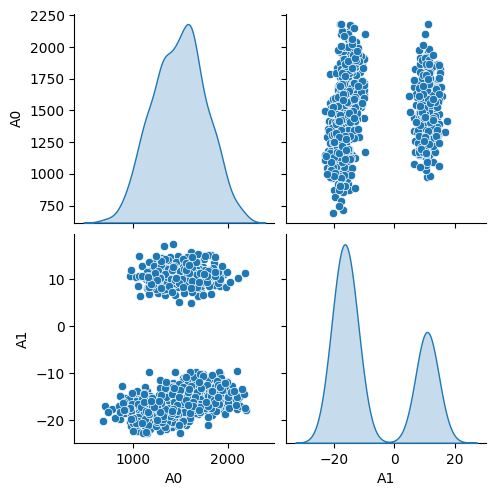

In [69]:
X_pruned2 = X.iloc[:,:-1]
print(f'Shape of X_pruned: {X_pruned2.shape}')
# produce a pairplot of X_pruned
plt.figure(figsize=(10, 10))
sns.pairplot(X_pruned2, diag_kind='kde');

Retrying the clustering scheme without feature A2, i.e only with A0 and A1

In [70]:
k=4
km_pruned2 = KMeans(n_clusters=k, 
            random_state=42)
y_km_pruned2 = km_pruned2.fit_predict(X_pruned2)
print("Number of clusters = {}\t- Distortion = {:6.2f}\t- Silhouette score = {:4.2f}"\
    .format(k,km_pruned.inertia_,silhouette_score(X_pruned2,y_km_pruned2)))

Number of clusters = 4	- Distortion = 2272.35	- Silhouette score = 0.54


Generating the pair confusion matrix and accuracy

In [71]:
pcm_pruned2 = pair_confusion_matrix(Y,y_km_pruned2)
pcm_pruned2=pcm_pruned2 / pcm_pruned2.sum()
print("Confusion Matrix")
print(pcm_pruned2,"\n")
print('The computed accuracy of the schema is {:.2f}%'.format(pcm_pruned2.diagonal().sum()*100))


Confusion Matrix
[[0.52153754 0.1457958 ]
 [0.20761962 0.12504705]] 

The computed accuracy of the schema is 64.66%


The accuracy does the increase and thus the preprocessing with pruning feature A0 produces best clustering